# Generate GeoJSON from Natural Earth Data

## Install Dependencies

```
pip install geopandas shapely matplotlib
```

## Download Data

Download datasets (_Admin 0 - Countries_ in [1:10](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/), and _Admin 1 – States, Provinces_ in 1:10 and [1:50](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/)) from Natural Earch Data:

In [1]:
import os
import requests

data_dir = os.path.expanduser("~/Downloads")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

def download_files(skip_existing=True):
    for url in [
        "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip",
        "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip",
        "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces.zip"
    ]:
        file_name = url.split('/')[-1]
        full_file_name = f'{data_dir}/{file_name}'
        with requests.get(
            url,
            headers={
                "accept-encoding": "gzip, deflate, br",
                "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36"
            },
            stream=True,
        ) as res:
            file_size = int(res.headers['content-length'])
            if res.status_code != 200:
                print("Error downloading files. Please open the URL to download them from browser manually.")
                break
            if (
                skip_existing and
                os.path.exists(full_file_name) and
                file_size == os.path.getsize(full_file_name)
            ):
                print(f"Skip {file_name} because it already exists")
                continue
            print(f"Downloading {file_name}... \r", end="")
            with open(full_file_name, "wb") as fh:
                fh.write(res.content)
    print("Done.                                                               ")

download_files(skip_existing=True)

Skip ne_10m_admin_0_countries.zip because it already exists
Skip ne_10m_admin_1_states_provinces.zip because it already exists
Skip ne_50m_admin_1_states_provinces.zip because it already exists
Done.                                                               


In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely

df_admin0_10m = gpd.read_file(f"{data_dir}/ne_10m_admin_0_countries.zip")
df_10m = gpd.read_file(f"{data_dir}/ne_10m_admin_1_states_provinces.zip")
df_50m = gpd.read_file(f"{data_dir}/ne_50m_admin_1_states_provinces.zip")

In [3]:
df_50m.columns

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=121)

In [4]:
df_admin0_10m.columns = df_admin0_10m.columns.str.lower()
df_admin0_10m.columns

Index(['featurecla', 'scalerank', 'labelrank', 'sovereignt', 'sov_a3',
       'adm0_dif', 'level', 'type', 'admin', 'adm0_a3',
       ...
       'fclass_tr', 'fclass_id', 'fclass_pl', 'fclass_gr', 'fclass_it',
       'fclass_nl', 'fclass_se', 'fclass_bd', 'fclass_ua', 'geometry'],
      dtype='object', length=162)

In [5]:
df_50m.groupby('admin').count()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
admin,,,,,,,,,,,,,,,,,,,,,
Australia,9,9,9,9,9,0,9,9,9,0,...,0,0,0,0,0,0,0,0,0,9
Brazil,27,27,27,27,27,0,27,27,27,13,...,0,0,0,0,0,0,0,0,0,27
Canada,13,13,13,13,13,13,13,13,13,9,...,0,0,0,0,0,0,0,0,0,13
China,31,31,31,31,31,0,31,31,31,30,...,0,0,0,0,0,0,0,0,0,31
India,36,36,36,36,36,0,36,36,36,13,...,0,0,0,0,0,0,0,0,0,36
Indonesia,33,33,33,33,33,0,33,33,33,30,...,0,0,0,0,0,0,0,0,0,33
Russia,85,85,85,85,85,1,85,85,85,84,...,0,0,0,0,0,0,0,0,0,85
South Africa,9,9,9,9,9,0,9,9,9,9,...,0,0,0,0,0,0,0,0,0,9
United States of America,51,51,51,51,51,51,51,51,51,51,...,0,0,0,0,0,0,0,0,0,51


<AxesSubplot:>

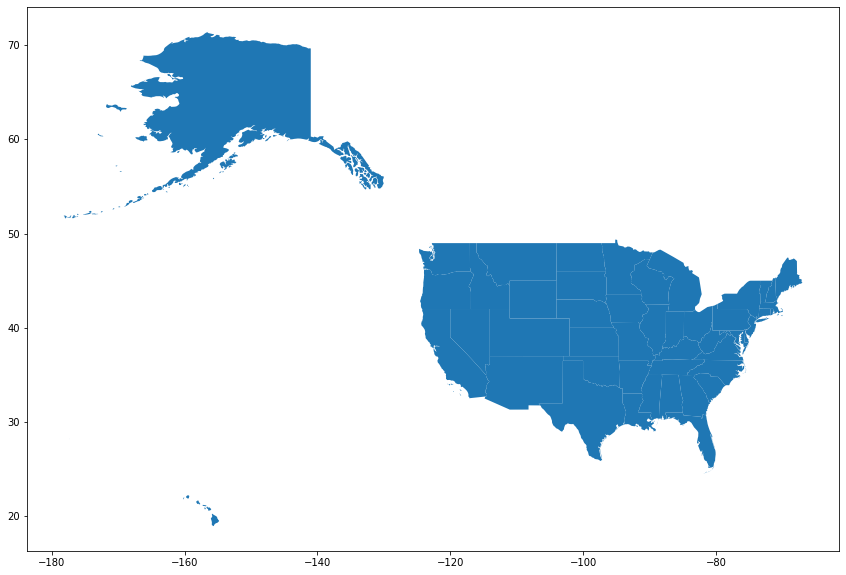

In [6]:
df_50m[df_50m.adm0_a3 == 'USA'].plot(figsize=(20,10))

Use 1:50m geometry for some large countries:

In [7]:
df_50m['admin'].unique()

array(['Australia', 'Brazil', 'Canada', 'United States of America',
       'China', 'India', 'Indonesia', 'Russia', 'South Africa'],
      dtype=object)

In [8]:
import pandas as pd

df = pd.concat([df_10m[~df_10m['admin'].isin(df_50m['admin'].unique())], df_50m])

## Adjust the Maps

<span style="color: red; font-size: 1.5em">TO SUPPORT NEW COUNTRIES, ADD COUNTRY NAME BELOW</span>

In [9]:
# Country names used in file names
countries = [
  'aland',
  'australia',
  'belgium',
  'brazil',
  'bulgaria',
  'burundi',
  'canada',
  'china',
  'denmark',
  'egypt',
  'estonia',
  'ethiopia',
  'france',
  'finland',
  'germany',
  'iceland',
  'india',
  'indonesia',
  'iran',
  'italy',
  'japan',
  'kenya',
  'korea',
  'liechtenstein',
  'malaysia',
  'mexico',
  'morocco',
  'myanmar',
  'netherlands',
  'nigeria',
  'norway',
  'portugal',
  'poland',
  'russia',
  'rwanda',
  'singapore',
  'slovenia',
  'spain',
  'sweden',
  'switzerland',
  'syria',
  'tanzania',
  'thailand',
  'timorleste',
  'uganda',
  'uk',
  'ukraine',
  'uruguay',
  'usa',
  'zambia',
]

# country name used in dataset
country_name_aliases = {
    "uk": "united kingdom",
    "usa": "united states of america",
    "korea": "south korea",
    "timorleste": "east timor",
    "tanzania": "united republic of tanzania",
}

# Make sure all country names are covered:
invalid_countries = [x for x in countries if country_name_aliases.get(x, x) not in df["admin"].str.lower().unique()]
if invalid_countries:
  print(f"Following country names are not valid: {invalid_countries}")

Preview all countries:

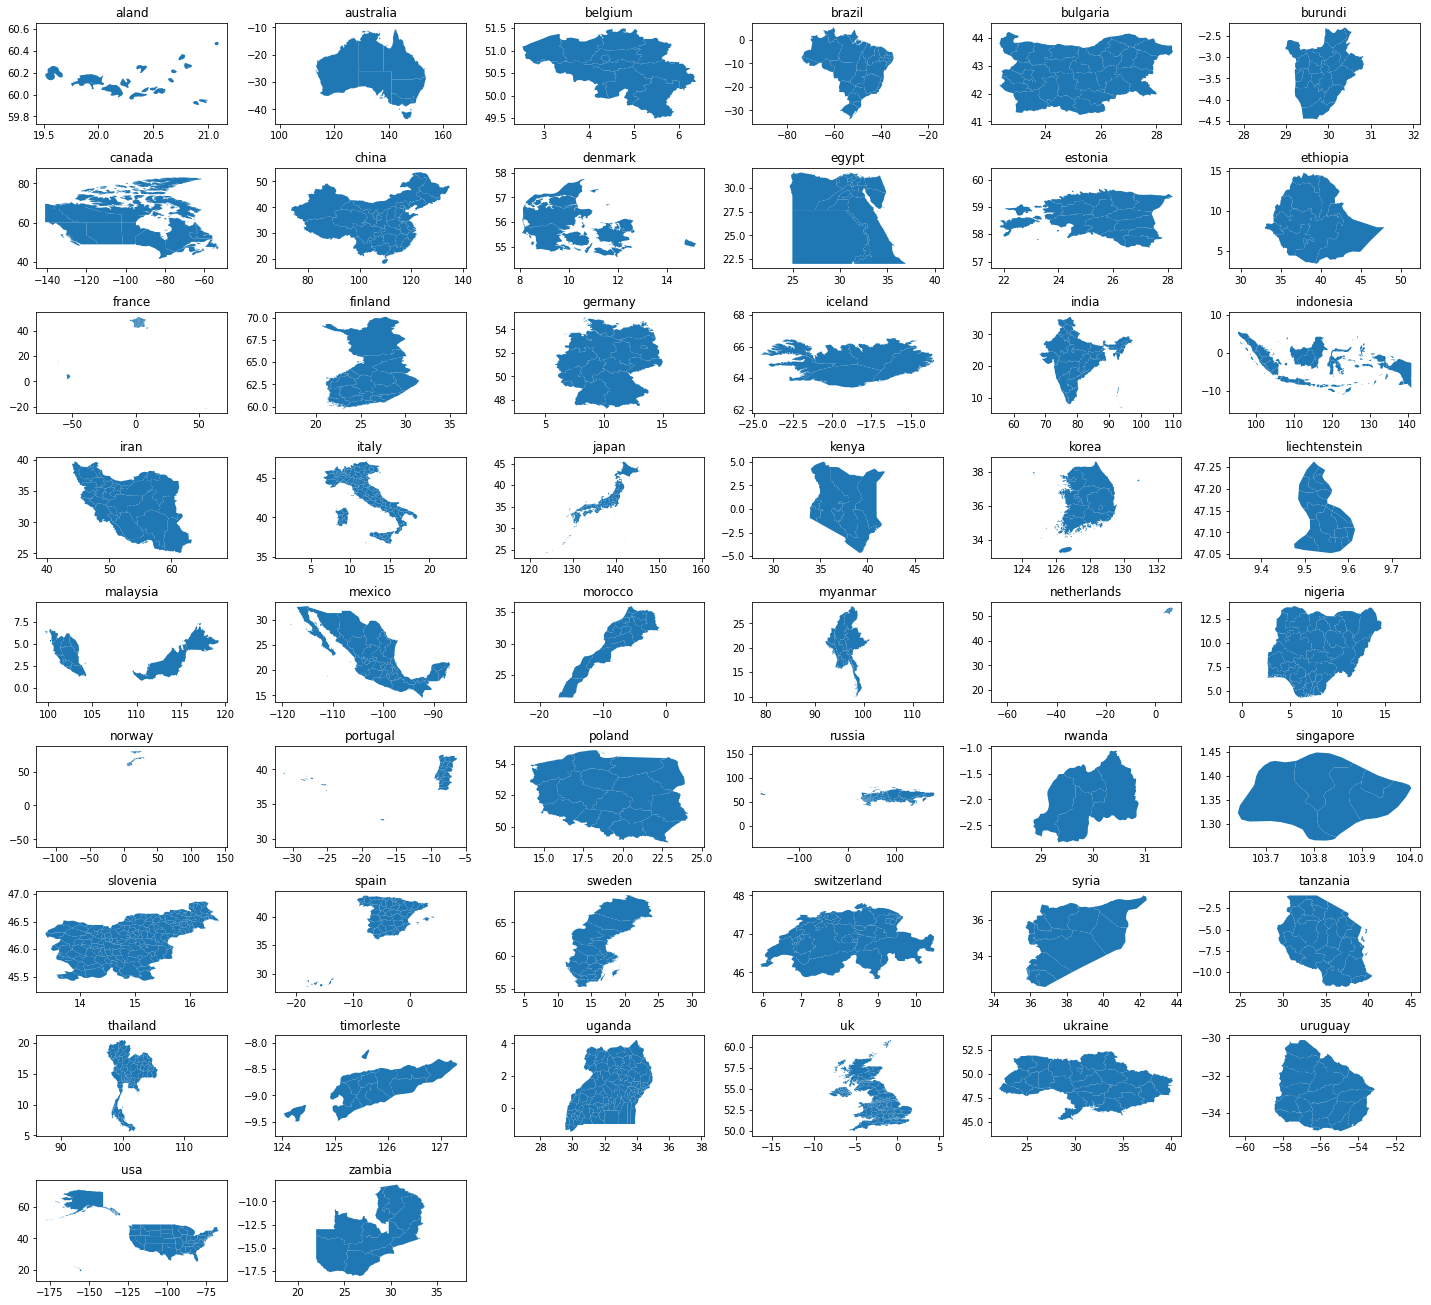

In [10]:
alt_maps = dict()

def get_gdf(country):
    country_alias = country_name_aliases.get(country, country)
    if country in alt_maps:
        gdf = alt_maps[country]
    else:
        gdf = df[df["admin"].str.lower() == country_alias]
    return gdf.copy()

def plot_all_countries():
    plt.figure(figsize=(20, 20))

    for i, country in enumerate(countries):
        # create subplot axes in a 3x3 grid
        ax = plt.subplot(len(countries) // 5, 6, i + 1) # nrows, ncols, axes position
        get_gdf(country).plot(ax=ax)
        ax.set_title(country)
        ax.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.show()

plot_all_countries()

### Handle countries with flying islands

#### USA

For countries with flying islands, we need to move the islands closer to the mainland.

<AxesSubplot:>

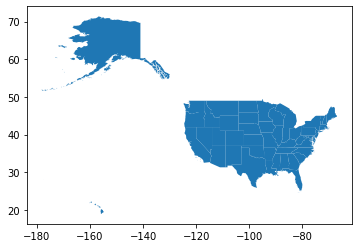

In [11]:
usa = df[df['adm0_a3'] == 'USA']
usa.plot()

<AxesSubplot:>

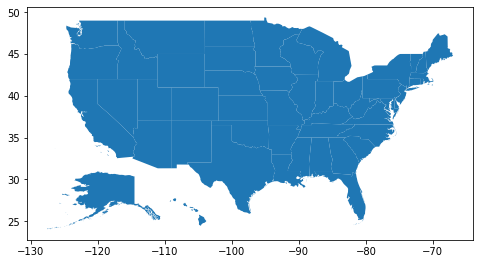

In [12]:
def reposition(df, idx, xoff=None, yoff=None, xscale=None, yscale=None, simplify=None):
    
    def move_and_scale(series):
        if xoff or yoff:
            series = shapely.affinity.translate(series, xoff or 0, yoff or 0)
        if xscale or yscale:
            series = shapely.affinity.scale(series, xscale or 1, yscale or 1)
        if simplify:
            series = series.simplify(simplify, preserve_topology=False)
        return series
    
    df.loc[idx, 'geometry'] = df.loc[idx, 'geometry'].apply(move_and_scale)


usa_copy = usa.copy()
reposition(usa_copy, usa.name == 'Hawaii', 51, 5.5)
reposition(usa_copy, usa.name == 'Alaska', 35, -34, 0.35, 0.35)

usa_copy.plot(figsize=(8,8))

#### China

China claims sovereign over Taiwan. For disputed territories, we respect each country and give them what they want.

In addition, Hong Kong and Macau should also be included in a China map.

In [13]:
# Chinese Special Administrative Regions
china_sars = df_admin0_10m.loc[
    df_admin0_10m.name_en.isin(['Taiwan', 'Hong Kong', 'Macau']),
    [x for x in df_admin0_10m.columns if x in df.columns]
]
china_sars = china_sars.merge(pd.DataFrame(
    data={ 
        "name_en": ["Taiwan", "Hong Kong", "Macau"],
        "name_zh": ["中国台湾", "香港特别行政区", "澳门特别行政区"],
        "iso_3166_2": ["CN-71", "CN-91", "CN-92"],
    },
), on="name_en", how="left")
china_sars

,featurecla,scalerank,labelrank,sov_a3,type,admin,adm0_a3,gu_a3,name,abbrev,...,name_sv,name_tr,name_uk,name_ur,name_vi,name_zh_x,name_zht,geometry,name_zh_y,iso_3166_2
0,Admin-0 country,0,4,CH1,Country,Hong Kong S.A.R.,HKG,HKG,Hong Kong,H.K.,...,Hongkong,Hong Kong,Гонконг,ہانگ کانگ,Hồng Kông,香港,香港,"MULTIPOLYGON (((114.22983 22.55581, 114.23471 ...",香港特别行政区,CN-91
1,Admin-0 country,0,3,TWN,Sovereign country,Taiwan,TWN,TWN,Taiwan,Taiwan,...,Taiwan,Çin Cumhuriyeti,Республіка Китай,تائیوان,Đài Loan,中华民国,中華民國,"MULTIPOLYGON (((121.90577 24.95010, 121.83473 ...",中国台湾,CN-71
2,Admin-0 country,0,4,CH1,Country,Macao S.A.R,MAC,MAC,Macao,Mac.,...,Macao,Makao,Аоминь,مکاؤ,Ma Cao,澳门,澳門,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",澳门特别行政区,CN-92


/var/folders/yk/yj8t31wd1sd_9w0f9cfg5jv80000gn/T/ipykernel_82121/3440732423.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  china_copy = china.append(china_sars)


<AxesSubplot:>

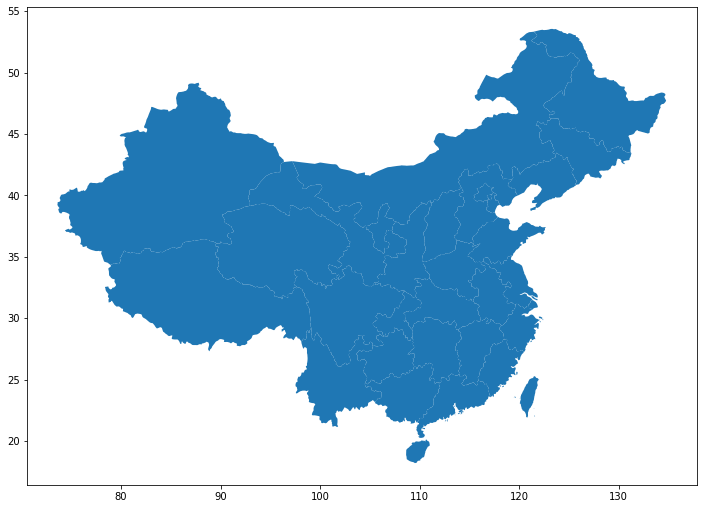

In [14]:
china = df[df.admin == "China"]
china_copy = china.append(china_sars)
china_copy["name_zh"] = china_copy["name_zh"].combine_first(china_copy["name_zh_y"])
china_copy = china_copy.drop(["name_zh_x", "name_zh_y"], axis=1)
china_copy.plot(figsize=(12, 12))

Note [ISO-3166-2:CN](https://en.wikipedia.org/wiki/ISO_3166-2:CN) has updated subdivisions to use letters instead of numbers (e.g. `CN-91` -> `CN-HK`). We kept the numeric code for backward compatibility.

#### Finland

The Åland Islands (ISO country code AX) is an autonomous region of Finland, and carries the ISO-3166 code FI-01. 

In [15]:
finland_aland = df_admin0_10m.loc[
    df_admin0_10m.name_en.isin(['Åland Islands']),
    [x for x in df_admin0_10m.columns if x in df.columns]
]
finland_aland = finland_aland.merge(pd.DataFrame(
    data={ 
        "name_en": ["Åland Islands"],
        "name_fi": ["Ahvenanmaan maakunta"],
        "iso_3166_2": ["FI-01"],
    },
), on="name_en", how="left")


/var/folders/yk/yj8t31wd1sd_9w0f9cfg5jv80000gn/T/ipykernel_82121/642512976.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finland_copy = finland.append(finland_aland)


<AxesSubplot:>

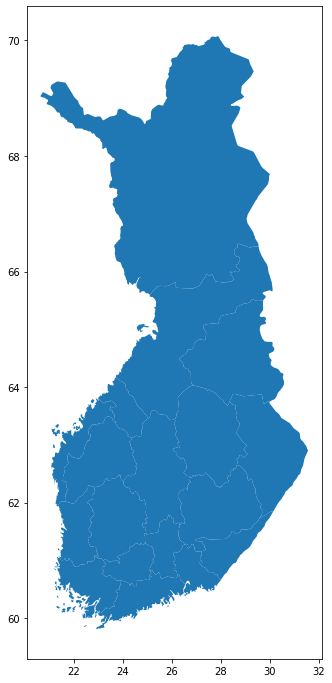

In [16]:
finland = df[df.admin == "Finland"]
finland_copy = finland.append(finland_aland)
finland_copy["name_fi"] = finland_copy["name_fi"].combine_first(finland_copy["name_fi"])
finland_copy = finland_copy.drop(["name_fi"], axis=1)
finland_copy.plot(figsize=(12, 12))

#### Norway

Remove NO-X01~ (The uninhabited Bouvet Island) and move Svalbard closer to mainland

<AxesSubplot:>

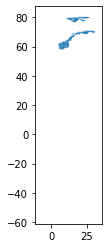

In [17]:
norway = df[df['adm0_a3'] == 'NOR']
norway.plot()

<AxesSubplot:>

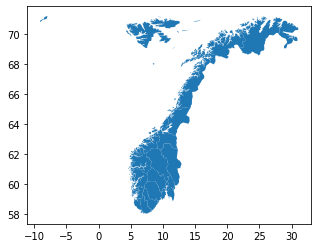

In [18]:
norway_copy = norway.copy()
norway_copy = norway_copy[norway_copy["iso_3166_2"] != "NO-X01~"]
reposition(norway_copy, norway.name == 'Svalbard', -12, -8, 0.5, 0.5)
#reposition(norway_copy, norway.name == 'Nordland', 10, 0, 2, 2)

norway_copy.plot()

#### Portugal

<AxesSubplot:>

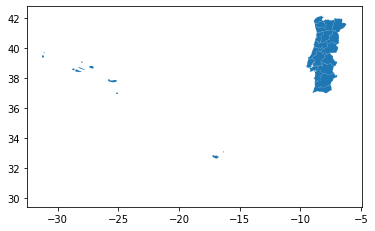

In [19]:
portugal = df[df.admin == 'Portugal']
portugal.plot()

<AxesSubplot:>

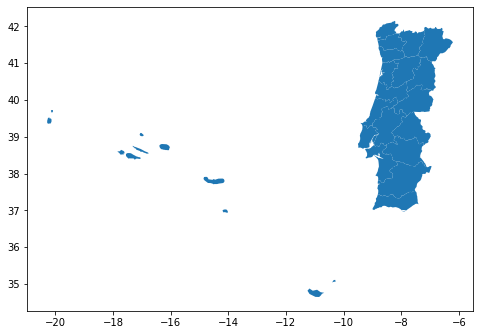

In [20]:
portugal_copy = portugal.copy()
reposition(portugal_copy, portugal.name == 'Azores', 11, 0)
reposition(portugal_copy, portugal.name == 'Madeira', 6, 2, simplify=0.015)
portugal_copy.plot(figsize=(8, 8))

#### Spain

<AxesSubplot:>

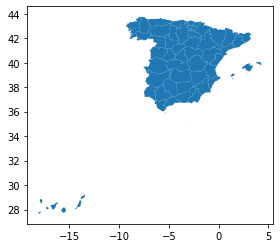

In [21]:
spain = df[df.admin == 'Spain']
spain.plot()

<AxesSubplot:>

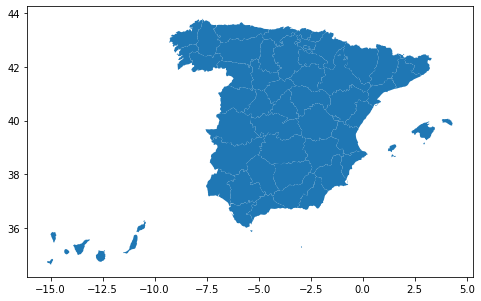

In [22]:
spain_copy = spain.copy()
reposition(spain_copy, spain.name.isin(['Las Palmas', 'Santa Cruz de Tenerife']), 3, 7, 1, 1)
spain_copy.plot(figsize=(8, 8))

#### Russia

<AxesSubplot:>

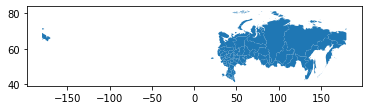

In [23]:
russia = df[df.admin == 'Russia']
russia.plot()

Russia looks off because of Chukchi runs across E180. We need to move the parts on the other side of the map to the right.

/var/folders/yk/yj8t31wd1sd_9w0f9cfg5jv80000gn/T/ipykernel_82121/127064943.py:6: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for item in splitted_geom:


<AxesSubplot:>

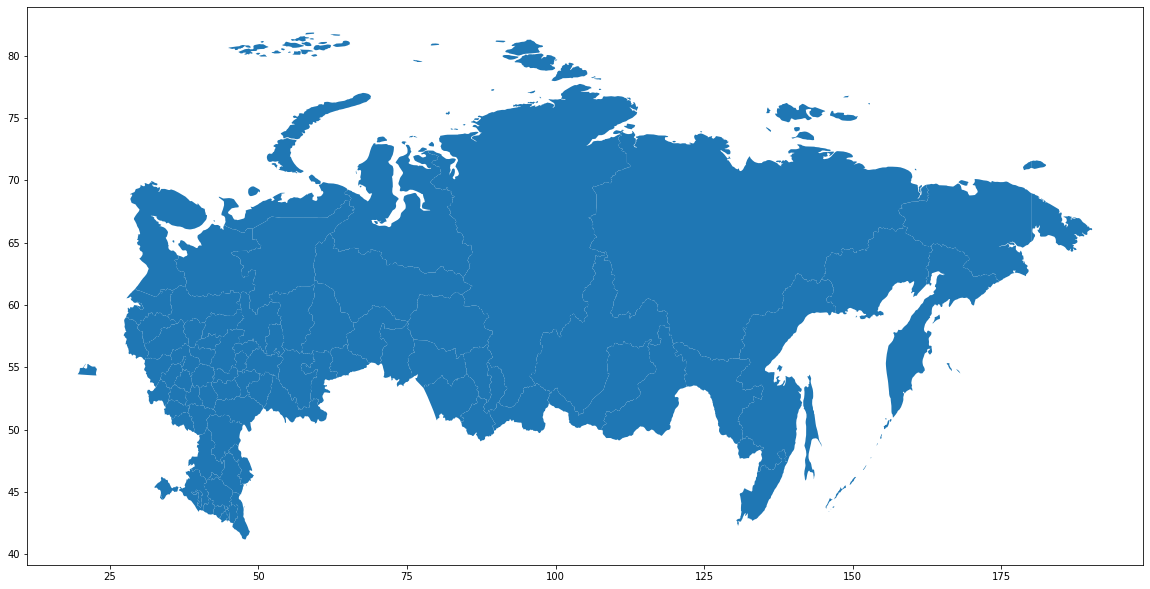

In [24]:
def shift_geom(geom, cutoff=0):
    border = shapely.geometry.LineString([(cutoff,-90),(cutoff, 90)])
    splitted_geom = shapely.ops.split(geom, border)
    moved_geom = []

    for item in splitted_geom:
        minx, miny, maxx, maxy = item.bounds
        if minx < cutoff:
            moved_geom.append(shapely.affinity.translate(item, xoff=cutoff + 360))
        else:
            moved_geom.append(item)

    # got `moved_geom` as the moved geometry            
    return shapely.ops.unary_union(moved_geom)

russia_copy = russia.copy()
russia_copy.loc[
    russia.name == 'Chukchi Autonomous Okrug', 'geometry'
] = russia_copy.loc[
    russia.name == 'Chukchi Autonomous Okrug', 'geometry'
].apply(shift_geom)

russia_copy = russia_copy

russia_copy.plot(figsize=(20, 20))

#### France

<AxesSubplot:>

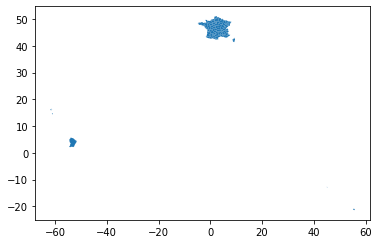

In [25]:
france = df[df.admin == 'France']
france.plot()

Ignore all the oversea islands

<AxesSubplot:>

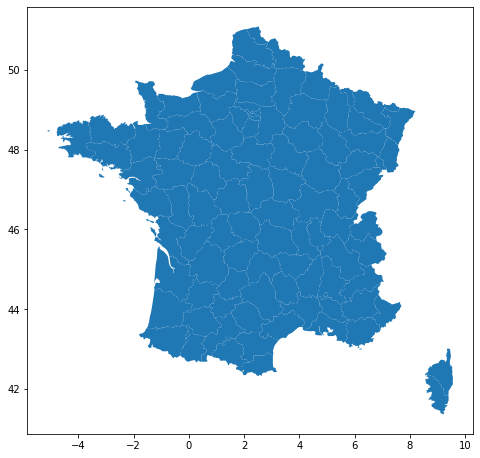

In [26]:
def apply_bounds(df, northwest, southeast):
    x1, y1 = northwest
    x2, y2 = southeast
    boundry = shapely.geometry.Polygon([(x1, y1),(x1, y2), (x2, y2), (x2, y1)])
    df = df.copy()
    return df[df.geometry.apply(lambda x: boundry.contains(x))]

france_copy = apply_bounds(france, (-20, 60), (20, 20))
france_copy.plot(figsize=(8, 8))

#### Netherlands

<AxesSubplot:>

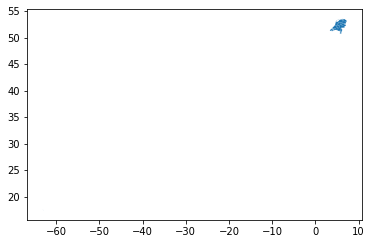

In [27]:
netherlands = df[df.admin == 'Netherlands']
netherlands.plot()

<AxesSubplot:>

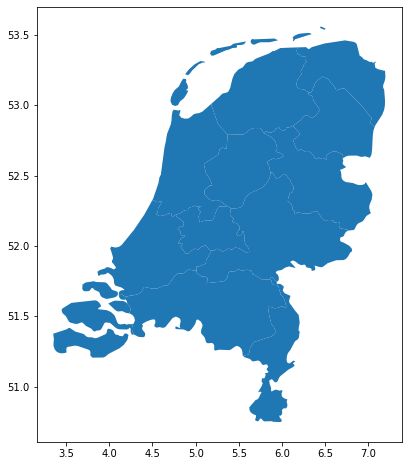

In [28]:
netherlands_copy = apply_bounds(netherlands, (-20, 60), (20, 20))
netherlands_copy.plot(figsize=(8, 8))

#### UK

<AxesSubplot:>

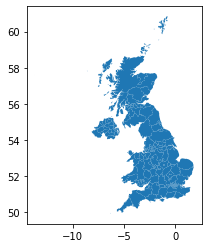

In [29]:
uk = df[df.admin == 'United Kingdom']
uk.plot()

<AxesSubplot:>

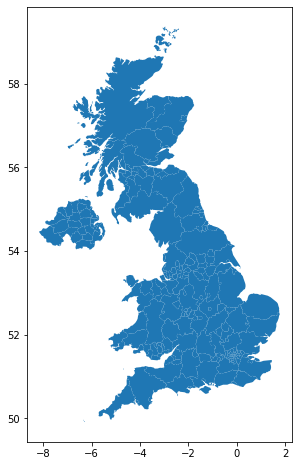

In [30]:
uk_copy = apply_bounds(uk, (-10, 60), (20, 20))
uk_copy.plot(figsize=(8, 8))

## Output GeoJSON

In [31]:
alt_maps = {
    "finland": finland_copy,
    "china": china_copy,
    "usa": usa_copy,
    "france": france_copy,
    "netherlands": netherlands_copy,
    "norway": norway_copy,
    "uk": uk_copy,
    "russia": russia_copy,
    "spain": spain_copy,
    "portugal": portugal_copy,
}

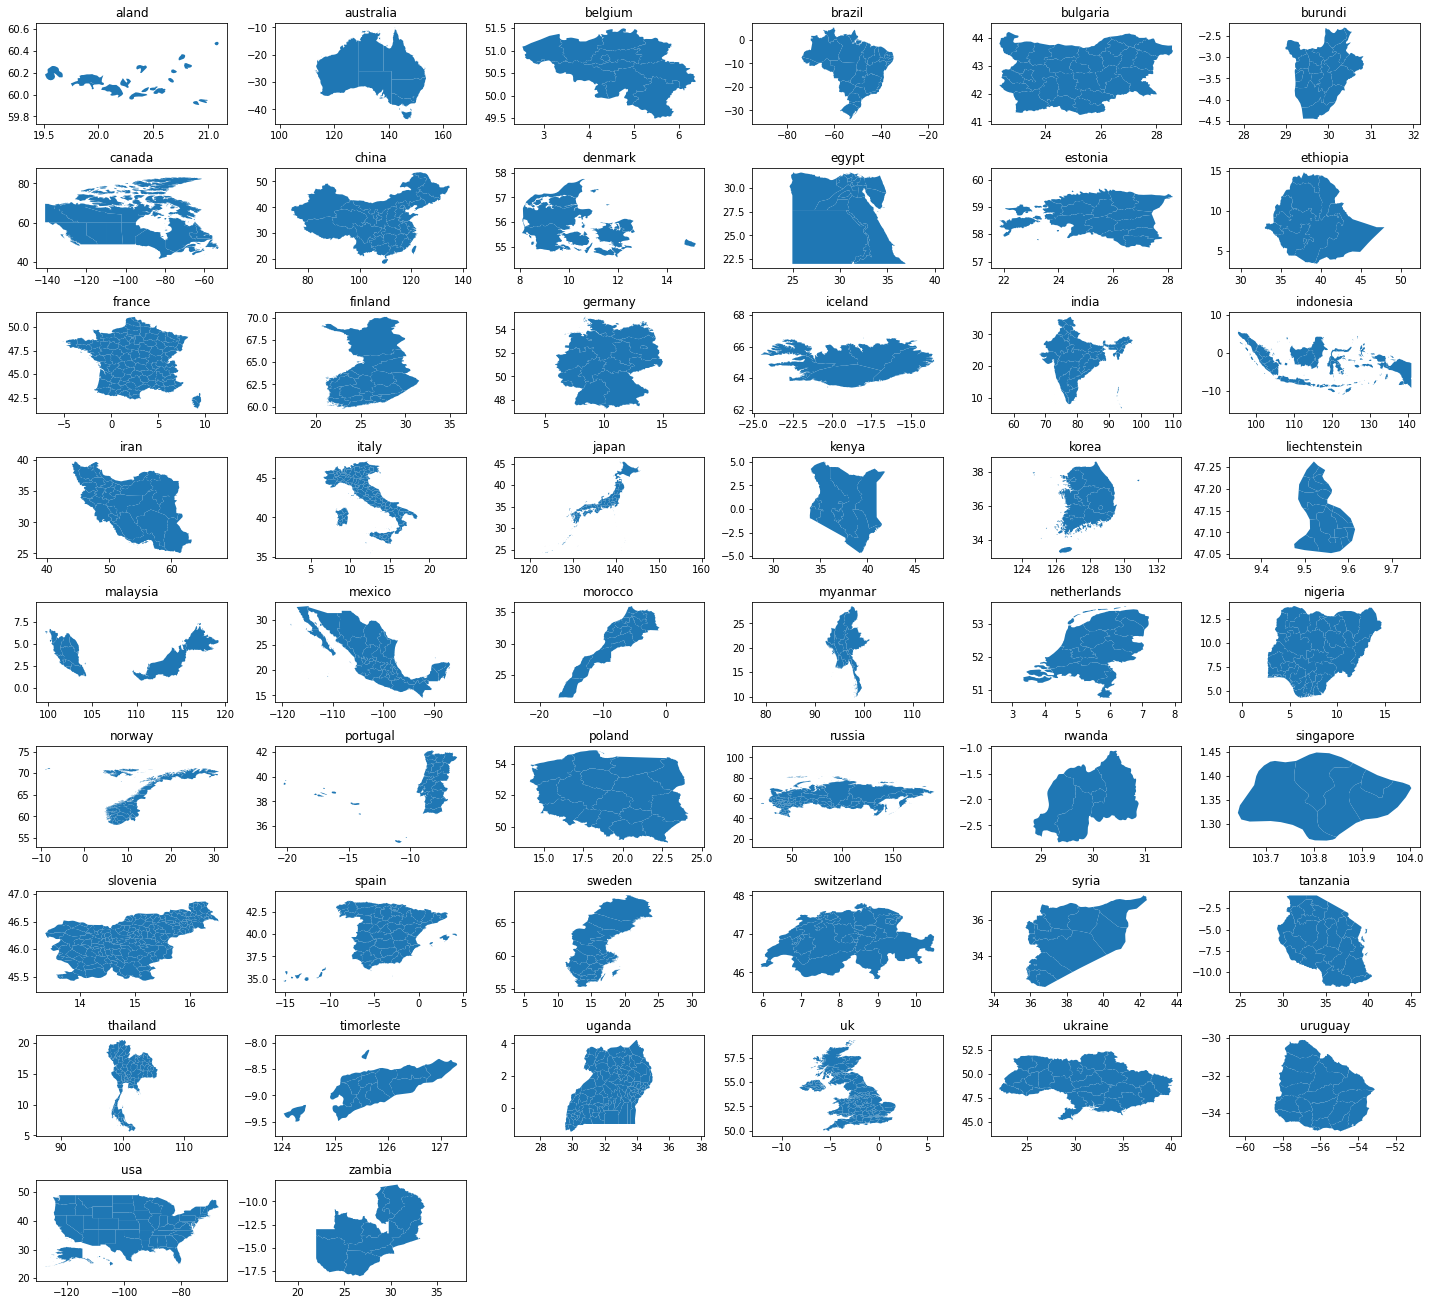

In [32]:
plot_all_countries()

In [33]:
simplify_factors = {
    "uk": 0.005,
}
useful_columns = ["ISO", "NAME_1", "geometry"]

def get_simplify_factor_by_size(gdf):
    xmin, ymin, xmax, ymax = shapely.ops.unary_union(gdf["geometry"]).bounds
    size = (xmax - xmin) * (ymax - ymin)
    print("Size", round(size, 3), end="\t")
    if size > 1000: return 0.03
    if size > 300: return 0.02
    if size > 100: return 0.01
    return 0
    
def simplify_if_needed(country, gdf):
    """Simplify the maps based on country size"""
    country_alias = country_name_aliases.get(country, country)
    if country_alias in df_50m["admin"].str.lower().unique():
        return
    
    factor = simplify_factors.get(country) or get_simplify_factor_by_size(gdf)
        
    if factor:
        gdf["geometry"] = gdf.simplify(factor)

def save_geojson(country):
    gdf = get_gdf(country)
    print(country, end="\t")
    
    # For backward compatibility
    gdf["ISO"] = gdf["iso_3166_2"]
    gdf["NAME_1"] = gdf["name"]
    
    simplify_if_needed(country, gdf)
        
    print(f'Saving geojson for {country}...')
    gdf[useful_columns].to_file(f"../src/countries/{country}.geojson", driver="GeoJSON")

for country in countries:
    save_geojson(country)
    
print("Done.                          ")

aland	Size 0.913	Saving geojson for aland...
australia	Saving geojson for australia...
belgium	Size 7.709	Saving geojson for belgium...
brazil	Saving geojson for brazil...
bulgaria	Size 18.715	Saving geojson for bulgaria...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

burundi	Size 3.99	Saving geojson for burundi...
canada	Saving geojson for canada...
china	Saving geojson for china...
denmark	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

Size 22.461	Saving geojson for denmark...
egypt	Size 117.982	Saving geojson for egypt...
estonia	Size 13.694	Saving geojson for estonia...
ethiopia	Size 172.021	Saving geojson for ethiopia...
france	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Size 142.834	Saving geojson for france...
finland	Size 112.354	Saving geojson for finland...
germany	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Size 71.47	Saving geojson for germany...
iceland	Size 34.959	Saving geojson for iceland...
india	Saving geojson for india...
indonesia	Saving geojson for indonesia...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

iran	Size 284.014	Saving geojson for iran...
italy	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Size 138.162	Saving geojson for italy...
japan	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Size 661.569	Saving geojson for japan...
kenya	Size 77.61	Saving geojson for kenya...
korea	Size 34.227	Saving geojson for korea...
liechtenstein	Size 0.029	Saving geojson for liechtenstein...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

malaysia	Size 127.7	Saving geojson for malaysia...
mexico	Size 575.302	Saving geojson for mexico...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

morocco	Size 231.84	Saving geojson for morocco...
myanmar	Size 168.709	Saving geojson for myanmar...
netherlands	Size 10.818	Saving geojson for netherlands...
nigeria	Size 115.287	Saving geojson for nigeria...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


norway	Size 530.052	Saving geojson for norway...
portugal	Size 105.727	Saving geojson for portugal...
poland	Size 58.556	Saving geojson for poland...
russia	Saving geojson for russia...
rwanda	Size 3.59	Saving geojson for rwanda...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

singapore	Size 0.067	Saving geojson for singapore...
slovenia	Size 4.537	Saving geojson for slovenia...
spain	Size 178.488	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Saving geojson for spain...
sweden	Size 178.774	Saving geojson for sweden...
switzerland	Size 8.935	Saving geojson for switzerland...
syria	Size 33.348	Saving geojson for syria...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int6

tanzania	Size 119.579	Saving geojson for tanzania...
thailand	Size 122.959	

/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Saving geojson for thailand...
timorleste	Size 4.486	Saving geojson for timorleste...
uganda	Size 31.083	Saving geojson for uganda...
uk	Saving geojson for uk...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


ukraine	Size 128.988	Saving geojson for ukraine...
uruguay	Size 25.985	Saving geojson for uruguay...
usa	Saving geojson for usa...


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


zambia	Size 115.483	Saving geojson for zambia...
Done.                          


/Users/yann/Library/Python/3.8/lib/python/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
